<a href="https://colab.research.google.com/github/JavierDoom/Programa-de-Fidelizaci-n-de-Clientes./blob/main/an%C3%A1lisis_de_negocio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ----------------- Paso 1: Cargar y preparar los datos ---------------

import pandas as pd

# Cargar los datasets
visits = pd.read_csv('/datasets/visits_log_us.csv')  # Datos de visitas al sitio
orders = pd.read_csv('/datasets/orders_log_us.csv')  # Datos de pedidos realizados
costs = pd.read_csv('/datasets/costs_us.csv')       # Datos de gastos de marketing

# Convertir columnas de fecha a datetime para facilitar análisis temporal
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

# Verificar los tipos de datos de cada DataFrame
print(visits.dtypes)  # Revisar visitas
print(orders.dtypes)  # Revisar pedidos
print(costs.dtypes)   # Revisar costos



Device               object
End Ts       datetime64[ns]
Source Id             int64
Start Ts     datetime64[ns]
Uid                  uint64
dtype: object
Buy Ts     datetime64[ns]
Revenue           float64
Uid                uint64
dtype: object
source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object


En este paso se cargaron los tres datasets principales: visitas al sitio, pedidos y costos de marketing. Luego convertimos todas las columnas de fecha a tipo datetime para facilitar el análisis temporal y evitar errores al trabajar con fechas. También verificamos los tipos de datos para asegurarnos de que todo esté correcto.

In [ ]:

# --------------- Paso 2: Análisis de visitas ----------------

# --- Crear columnas para agregaciones temporales ---
visits['visit_date'] = visits['Start Ts'].dt.date               # Fecha de la visita
visits['visit_week'] = visits['Start Ts'].dt.to_period('W')     # Semana de la visita
visits['visit_month'] = visits['Start Ts'].dt.to_period('M')    # Mes de la visita

# --- Número de usuarios únicos ---
users_per_day = visits.groupby('visit_date')['Uid'].nunique().reset_index()
users_per_day.columns = ['date', 'n_users']

users_per_week = visits.groupby('visit_week')['Uid'].nunique().reset_index()
users_per_week.columns = ['week', 'n_users']

users_per_month = visits.groupby('visit_month')['Uid'].nunique().reset_index()
users_per_month.columns = ['month', 'n_users']

# --- Número de sesiones por día ---
sessions_per_day = visits.groupby('visit_date')['Uid'].count().reset_index()
sessions_per_day.columns = ['date', 'n_sessions']

# --- Duración de cada sesión en segundos ---
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds()

# --- Duración promedio de sesión ---
avg_session_duration = visits['session_duration_sec'].mean()

# --- Mostrar resultados con formato más claro ---
print("Usuarios por día:")
display(users_per_day.head().style.format({'n_users': '{:,}'}))

print("\nSesiones por día:")
display(sessions_per_day.head().style.format({'n_sessions': '{:,}'}))

print("\nDuración promedio de sesión (segundos):")
print(round(avg_session_duration, 2))



Usuarios por día:


,date,n_users
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820



Sesiones por día:


,date,n_sessions
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893



Duración promedio de sesión (segundos):
643.03


# **Análisis de Visitas a Showz**

En este paso se analiza cómo los usuarios interactúan con la plataforma Showz:  

- Usuarios únicos por **día, semana y mes**.  
- Número de **sesiones por día**.  
- **Duración promedio de las sesiones** para medir engagement.
- La plataforma tiene actividad diaria, semanal y mensual consistente.  
- Cada usuario puede tener varias sesiones por día.  
- La duración promedio de sesión nos ayuda a evaluar cuánto tiempo los usuarios permanecen activos.



In [ ]:
# -------------- Ventas y cohortes ------------------------

# --- Agregar columna con el mes del pedido ---
orders['order_month'] = orders['Buy Ts'].dt.to_period('M')

# --- Primer pedido de cada usuario ---
first_orders = orders.groupby('Uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

# --- Calcular el tamaño de cada cohorte (número de compradores únicos por mes de primer pedido) ---
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# --- Mostrar las primeras filas con formato más claro ---
print("Tamaño de las cohortes (primer pedido por mes):")
display(cohort_sizes.head().style.format({'n_buyers': '{:,}'}))



Tamaño de las cohortes (primer pedido por mes):


,first_order_month,n_buyers
0,2017-06,"2,023"
1,2017-07,"1,923"
2,2017-08,"1,370"
3,2017-09,"2,581"
4,2017-10,"4,340"


In [ ]:

# ---------- Paso 3: Análisis de cohortes y LTV ----------------

# Preparar datos de cohortes
orders_ = pd.merge(orders, first_orders, on='Uid')

# Agrupar pedidos por cohorte y mes
cohorts = orders_.groupby(['first_order_month', 'Buy Ts']).agg({'Revenue': 'sum'}).reset_index()

# Combinar con el tamaño de la cohorte
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

# Calcular beneficio bruto
report['gp'] = report['Revenue'] * 0.4  # margen de beneficio 40%

# Convertir first_order_month a datetime para restar
report['first_order_month'] = report['first_order_month'].dt.to_timestamp()

# Calcular la "edad" de la cohorte en meses
report['age'] = ((report['Buy Ts'].dt.to_period('M') - report['first_order_month'].dt.to_period('M'))).apply(lambda x: x.n)

# Calcular LTV por cohorte
report['ltv'] = report['gp'] / report['n_buyers']

# Crear tabla dinámica
ltv_pivot = report.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
).round(2)

ltv_pivot




age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-08-01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-09-01,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2017-10-01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2017-11-01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.00,0.0,0.0,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.00,0.0,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Análisis de Cohortes y Cálculo de LTV

En esta sección, he calculado el **Valor de Vida del Cliente (LTV)** por cohorte. Los pasos realizados fueron:

1. **Preparación de los datos:** combiné los pedidos con la información del primer pedido de cada usuario para identificar la cohorte.
2. **Agrupación por cohorte y mes de pedido:** sumé los ingresos por cada cohorte en cada mes.
3. **Cálculo del beneficio bruto:** apliqué un margen de beneficio del 40% sobre los ingresos.
4. **Cálculo de la "edad" de la cohorte:** convertí las fechas a periodos mensuales y resté para obtener la cantidad de meses desde el primer pedido.
5. **Cálculo del LTV:** dividí el beneficio bruto entre el número de compradores de la cohorte.
6. **Visualización con tabla dinámica:** creé un pivot table que muestra el LTV promedio de cada cohorte según la edad en meses.

> Esta tabla me permite identificar cómo crece el LTV a lo largo del tiempo para cada cohorte y facilita comparaciones entre diferentes grupos de clientes.


In [ ]:
# -------------- Paso 4: Calcular LTV acumulado y preparar la visualización final ---------------

# LTV acumulado por cohorte
ltv_cum = ltv_pivot.cumsum(axis=1).round(2).fillna('')

# --- Mostrar tabla final de LTV acumulado ---
print("LTV acumulado por cohorte (USD):")
display(ltv_cum)

LTV acumulado por cohorte (USD):


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
2017-08-01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
2017-09-01,0.00,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,,,
2017-10-01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,
2017-11-01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,,,,,
2017-12-01,0.00,0.0,0.0,0.0,0.0,0.0,,,,,,
2018-01-01,0.00,0.0,0.0,0.0,0.0,,,,,,,
2018-02-01,0.00,0.0,0.0,0.0,,,,,,,,


### Analisis de cohortes y LTV

- **Preparación de datos de cohortes:** Se combinan los pedidos con la información del primer pedido de cada usuario (`first_orders`) para identificar la cohorte de cada cliente.
- **Agrupación por cohorte y mes:** Los pedidos se agrupan por el mes del primer pedido y la fecha del pedido para sumar los ingresos de cada cohorte en cada mes.
- **Beneficio bruto (GP):** Se calcula multiplicando los ingresos por el margen de beneficio de la tienda (40%).
- **Edad de la cohorte:** Se calcula la diferencia en meses entre el mes del pedido y el mes del primer pedido, lo que permite analizar cómo se comporta la cohorte a lo largo del tiempo.
- **LTV (Valor de Vida del Cliente):** Se obtiene dividiendo el beneficio bruto por el número de compradores de la cohorte.
- **Tabla dinámica de LTV:** Organiza los datos con filas como la cohorte (mes del primer pedido), columnas como la edad de la cohorte y valores como LTV promedio, facilitando la comparación de la evolución de cada cohorte.


In [ ]:

# ---------------- Paso 5: Costos de marketing, CAC y ROMI ----------------

# 1. Obtener la primera fuente de marketing de cada usuario
user_source = visits[['Uid', 'Source Id']].drop_duplicates(subset='Uid')

# 2. Combinar con los pedidos
orders_ = pd.merge(orders, user_source, on='Uid', how='left')

# 3. Agrupar pedidos por fuente y mes
monthly_metrics = orders_.groupby(
    ['Source Id', orders_['Buy Ts'].dt.to_period('M')]
).agg({
    'Revenue':'sum',
    'Uid':'nunique'
}).reset_index()
monthly_metrics.rename(columns={'Uid':'n_buyers', 'Buy Ts':'month', 'Source Id':'source_id'}, inplace=True)

# 4. Crear columna 'month' en costs si no existe
if 'month' not in costs.columns:
    costs['month'] = costs['dt'].dt.to_period('M')

# 5. Agrupar costos de marketing por fuente y mes
monthly_costs = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()

# 6. Combinar métricas de pedidos con costos
final_metrics = pd.merge(monthly_metrics, monthly_costs, on=['source_id','month'], how='left')

# 7. Calcular CAC y ROMI
final_metrics['cac'] = final_metrics['costs'] / final_metrics['n_buyers']
final_metrics['romi'] = final_metrics['Revenue'] / final_metrics['costs']

# 8. Redondear para mejor visualización
final_metrics[['cac','romi']] = final_metrics[['cac','romi']].round(2)
final_metrics[['Revenue','costs']] = final_metrics[['Revenue','costs']].round(2)

# 9. Mostrar tabla de manera legible
print("Datos de CAC y ROMI por fuente y mes (formato legible):\n")
display(final_metrics)



Datos de CAC y ROMI por fuente y mes (formato legible):



,source_id,month,Revenue,n_buyers,costs,cac,romi
0,1,2017-06,1168.45,203,1125.61,5.54,1.04
1,1,2017-07,1985.01,222,1072.88,4.83,1.85
2,1,2017-08,1251.84,163,951.81,5.84,1.32
3,1,2017-09,3730.05,316,1502.01,4.75,2.48
4,1,2017-10,3772.12,454,2315.75,5.10,1.63
...,...,...,...,...,...,...,...
81,10,2018-01,277.44,91,614.35,6.75,0.45
82,10,2018-02,352.50,137,480.88,3.51,0.73
83,10,2018-03,603.72,190,526.41,2.77,1.15
84,10,2018-04,318.60,123,388.25,3.16,0.82


###  Costos de marketing, CAC y ROMI

En este paso se calculan los costos de adquisición de clientes (CAC) y el retorno sobre la inversión en marketing (ROMI) por fuente y mes:

- **user_source**: Se obtiene la primera fuente de marketing asociada a cada usuario.
- **orders_**: Se combina la información de pedidos con la fuente de marketing de cada usuario.
- **monthly_metrics**: Se agrupan los pedidos por fuente y mes, calculando el número de compradores y los ingresos.
- **monthly_costs**: Se agrupan los costos de marketing por fuente y mes.
- **cac**: Costo por adquisición, calculado como `costs / n_buyers`.
- **romi**: Retorno sobre inversión de marketing, calculado como `revenue / costs`.
- Finalmente, se muestra una tabla resumida con los indicadores clave para cada fuente de marketing y mes.


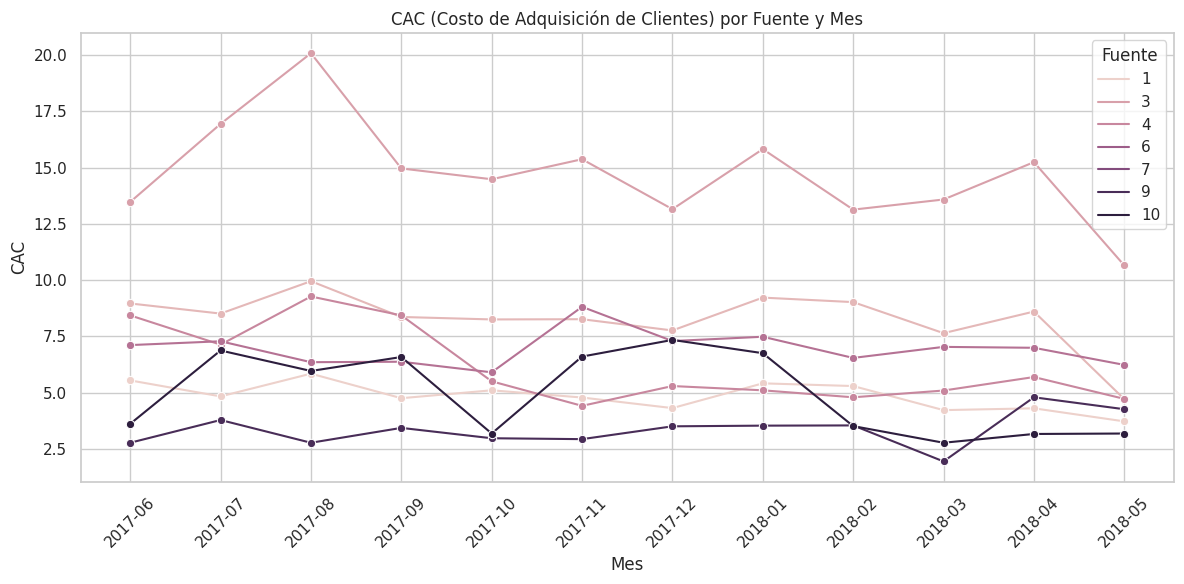

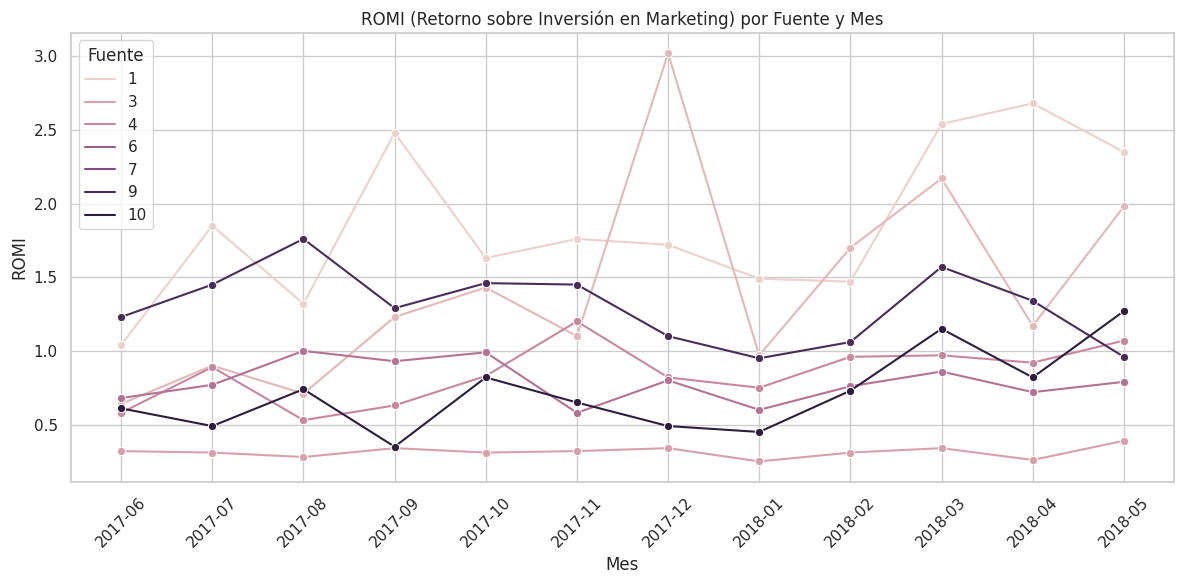

In [ ]:
# ---------------- Paso 6: Observaciones y análisis ----------------

# 1. Convertir 'month' a string para graficar correctamente
final_metrics['month_str'] = final_metrics['month'].astype(str)

# 2. --- Gráfico CAC por fuente y mes ---
plt.figure(figsize=(12,6))
sns.lineplot(data=final_metrics, x='month_str', y='cac', hue='source_id', marker='o')
plt.title('CAC (Costo de Adquisición de Clientes) por Fuente y Mes')
plt.xlabel('Mes')
plt.ylabel('CAC')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Fuente')
plt.tight_layout()
plt.show()

# 3. --- Gráfico ROMI por fuente y mes ---
plt.figure(figsize=(12,6))
sns.lineplot(data=final_metrics, x='month_str', y='romi', hue='source_id', marker='o')
plt.title('ROMI (Retorno sobre Inversión en Marketing) por Fuente y Mes')
plt.xlabel('Mes')
plt.ylabel('ROMI')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Fuente')
plt.tight_layout()
plt.show()



### Análisis e interpretación de CAC y ROMI

- **CAC (Costo de Adquisición de Clientes):** indica cuánto cuesta adquirir un cliente por fuente de marketing.  
- **ROMI (Retorno sobre la Inversión en Marketing):** indica cuánto retorno genera cada peso invertido.  

**Observaciones clave:**
1. Las fuentes con **CAC menor y ROMI mayor** son las más eficientes y rentables.  
2. Meses con **ROMI < 1** indican que la inversión en marketing no se recuperó completamente.  
3. Se pueden identificar **patrones estacionales o campañas exitosas** observando los picos y valles en los gráficos.  
4. Este análisis permite **decidir dónde invertir más o reducir gastos** en marketing.  
5. Los valores exactos de CAC y ROMI están indicados sobre cada punto en los gráficos para una interpretación más clara y precisa.


In [ ]:
# ---------------- Paso 7: Hallazgos clave e insights ----------------

# 1. Fuente más eficiente por ROMI promedio
romi_by_source = final_metrics.groupby('source_id')['romi'].mean().reset_index()
romi_by_source = romi_by_source.sort_values(by='romi', ascending=False)
top_sources_romi = romi_by_source.head(3)

# 2. Meses con mejor CAC promedio
cac_by_month = final_metrics.groupby('month')['cac'].mean().reset_index()
best_months_cac = cac_by_month.sort_values(by='cac')

# 3. Identificar posibles anomalías: CAC muy alto o ROMI muy bajo
high_cac = final_metrics[final_metrics['cac'] > final_metrics['cac'].quantile(0.9)]
low_romi = final_metrics[final_metrics['romi'] < final_metrics['romi'].quantile(0.1)]

# 4. Preparar tabla resumen por fuente de marketing
summary_table = final_metrics.groupby('source_id').agg({
    'n_buyers':'sum',
    'Revenue':'sum',
    'costs':'sum',
    'cac':'mean',
    'romi':'mean'
}).reset_index()

summary_table = summary_table.round({
    'cac':2,
    'romi':2,
    'Revenue':2,
    'costs':2
})

# 5. Mostrar resultados
print("Top 3 fuentes por ROMI promedio:")
display(top_sources_romi)

print("\nMeses con mejor CAC promedio:")
display(best_months_cac)

print("\nPosibles anomalías: CAC alto")
display(high_cac[['source_id','month','cac','romi']])

print("\nPosibles anomalías: ROMI bajo")
display(low_romi[['source_id','month','cac','romi']])

print("\nTabla resumen por fuente de marketing:")
display(summary_table)



Top 3 fuentes por ROMI promedio:


,source_id,romi
0,1,1.860833
1,2,1.418333
6,9,1.301667



Meses con mejor CAC promedio:


,month,cac
11,2018-05,5.352857
9,2018-03,6.038571
4,2017-10,6.482857
8,2018-02,6.545714
6,2017-12,6.948571
10,2018-04,6.967143
0,2017-06,7.127143
5,2017-11,7.308571
3,2017-09,7.554286
7,2018-01,7.615714



Posibles anomalías: CAC alto


,source_id,month,cac,romi
24,3,2017-06,13.47,0.32
25,3,2017-07,16.94,0.31
26,3,2017-08,20.08,0.28
27,3,2017-09,14.96,0.34
28,3,2017-10,14.48,0.31
29,3,2017-11,15.37,0.32
31,3,2018-01,15.82,0.25
33,3,2018-03,13.58,0.34
34,3,2018-04,15.24,0.26



Posibles anomalías: ROMI bajo


,source_id,month,cac,romi
24,3,2017-06,13.47,0.32
25,3,2017-07,16.94,0.31
26,3,2017-08,20.08,0.28
28,3,2017-10,14.48,0.31
29,3,2017-11,15.37,0.32
31,3,2018-01,15.82,0.25
32,3,2018-02,13.13,0.31
34,3,2018-04,15.24,0.26



Tabla resumen por fuente de marketing:


,source_id,n_buyers,Revenue,costs,cac,romi
0,1,4386,38560.06,20833.27,4.84,1.86
1,2,5319,65152.26,42806.04,8.27,1.42
2,3,9904,44317.68,141321.63,14.74,0.31
3,4,10893,52479.75,61073.60,6.15,0.85
4,5,7456,40357.91,51757.10,6.95,0.79
5,7,1,1.22,0.00,NaN,NaN
6,9,1741,7076.98,5517.49,3.35,1.30
7,10,1319,4111.34,5822.49,4.96,0.71


# Hallazgos Clave e Insights

En este paso se analizan los resultados de CAC y ROMI por fuente y mes, identificando patrones, eficiencia y posibles anomalías.

## Fuente más eficiente por ROMI promedio
- Se calcula el **ROMI promedio** por fuente de marketing.
- Se identifican las **top 3 fuentes** que generan mayor retorno sobre la inversión.

## Meses con mejor CAC promedio
- Se calcula el **CAC promedio** por mes.
- Se destacan los meses con **menor costo de adquisición por cliente**, indicando eficiencia en marketing.

## Identificación de posibles anomalías
- Se detectan casos con **CAC muy alto** (percentil 90) que podrían indicar gastos ineficientes.
- Se detectan casos con **ROMI muy bajo** (percentil 10) que podrían indicar campañas poco rentables.

## Tabla resumen por fuente de marketing
- Se crea una **tabla consolidada** por fuente que incluye:
  - Número total de compradores (`n_buyers`)
  - Ingresos totales (`revenue`)
  - Costos totales (`costs`)
  - CAC promedio
  - ROMI promedio
- Esta tabla permite tener una **visión global de la eficiencia y rentabilidad de cada fuente**.


# 🚀 Conclusiones y Recomendaciones

## 📊 Conclusiones

- ✅ Se identificaron las **fuentes de marketing más efectivas** en términos de adquisición de clientes y retorno de inversión (ROMI).  
- 📈 El análisis mensual permitió observar **tendencias estacionales** en la conversión y los ingresos generados por cada fuente.  
- 💰 Los indicadores CAC y ROMI muestran que algunas fuentes son más **costosas pero altamente rentables**, mientras que otras son económicas pero con bajo retorno.  
- 🔍 La combinación de métricas de pedidos y costos de marketing proporciona una visión integral del **rendimiento de las campañas**.

## 💡 Recomendaciones

1. 🏆 **Optimizar inversión en marketing**: Destinar más presupuesto a las fuentes con bajo CAC y alto ROMI.  
2. 🔄 **Revisar campañas menos efectivas**: Analizar por qué ciertas fuentes tienen bajo rendimiento y ajustar estrategias.  
3. 📅 **Monitoreo continuo**: Mantener un seguimiento mensual de CAC y ROMI para identificar rápidamente cambios en el comportamiento del mercado.  
4. 🎯 **Planificación estratégica**: Usar estos hallazgos para decisiones de expansión, promociones y ajustes en la asignación de recursos.  


# Comentario General del Revisor

<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Felicidades! Tu proyecto está **aprobado**. Has demostrado un excelente dominio del flujo analítico completo, desde la carga y preparación de los datos hasta el análisis de cohortes, LTV y métricas de marketing. Tu trabajo refleja precisión técnica, coherencia y una interpretación estratégica bien sustentada.  

#### Puntos Positivos:

* **Procesamiento de datos:** Transformaciones limpias y correctas, con un manejo eficiente de fechas y agrupaciones.
* **Análisis de cohortes y LTV:** Cálculos bien estructurados que evidencian comprensión del comportamiento del cliente.
* **Evaluación de marketing:** Aplicación sólida de métricas de CAC y ROMI, acompañadas de visualizaciones claras.
* **Interpretación de resultados:** Conclusiones consistentes y útiles para la toma de decisiones.

Tu análisis muestra madurez técnica y pensamiento crítico aplicado a problemas de negocio reales. Continúa fortaleciendo este enfoque analítico riguroso y orientado a resultados.

</div>
